In [1]:
import cv2
import tensorflow as tf
import os
import numpy as np
import network as net
import matplotlib.pyplot as plt
from scipy.ndimage.filters import maximum_filter
import math
from collections import Counter, defaultdict
import itertools
import matplotlib as mpl
import time
import ast
from scipy.ndimage.filters import gaussian_filter
import matplotlib
import json
import math
import time
from numpy import ma
from Open_Pose import OpenPose

C:\Users\SimJaekyu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Open_Pose.py Load Finish


In [2]:
image_path = './MPII_Dataset/test_set_288/image/'
list_index = [[0, 32, '000111209'], [32, 64, '000506158'], [64, 96, '000992321'], [96, 128, '001462854'], [128, 160, '001812404'], [160, 192, '002194147'], [192, 224, '003218440'], [224, 256, '003868496'], [256, 288, '004749422']]

In [3]:
def load_test_data_path(image_path):
    img_path = image_path
    file_path = []
    file_list = os.listdir(img_path)
    for i in (file_list):
        file_path.append(img_path + i)
    return file_path

def load_test_multi_data_path(image_path):
    img_path = image_path
    file_path = []
    file_list = os.listdir(img_path)
    for i in (file_list):
        file_path.append(img_path + i)
    return file_path

def path_to_image(img_path, batch_size):
    #buffer 선언
    image_data = np.zeros((batch_size, 356, 356, 3), np.uint8)
    
    index = 0
    for index, img in enumerate (img_path):
        image_data[index] = cv2.imread(img)
        
    image_data2 = data_normalize(image_data)
        
    return image_data, image_data2
def data_normalize(data):
    numerator = data - np.min(data, 0)
    denominator = 255.0
    #denominator = np.max(data, 0) - np.min(data, 0)
    
    return (numerator / (denominator))

def sum_of_channel(data):
    batch_size = len(data)
    tmp = np.zeros((batch_size, 44, 44))
    if(np.shape(data)[3] == 17):
        data = np.transpose(data, [0, 3, 1, 2])
        for i in range(batch_size):
            for j in range(16):
                tmp[i] = tmp[i] + data[i][j]
    elif(np.shape(data)[3] == 34):
        data = np.transpose(data, [0, 3, 1, 2])
        for i in range(batch_size):
            for j in range(32):
                tmp[i] = tmp[i] + data[i][j]
                
    return tmp

In [4]:
_index = 0

In [5]:
b_size = 32
with tf.Session() as sess:
    obj = OpenPose(batch_size = b_size, sess = sess, epochs=15)

    _from = list_index[_index][0]
    _to = list_index[_index][1]
    test_image = "./MPII_Dataset/test_set_288/image/%s.jpg"%list_index[_index][2]

    #file_path_tmp = load_test_multi_data_path()
    file_path_tmp = load_test_data_path(image_path)
    
    file_path = file_path_tmp[_from:_to]

    img_data, image_data = path_to_image(file_path, b_size)
    image_data = image_data[:, :, :, [2, 1, 0]]
    batch_img, heatmap, vectormap = obj.demo_test(image_data)

inint finish
test session
test data load
test weight load start
INFO:tensorflow:Restoring parameters from C:/Users/SimJaekyu/Documents/Jupyter Notebook/Open_Pose/Weight/Weight.ckpt
load weight successfully


In [6]:
np.shape(heatmap)

(32, 44, 44, 17)

In [7]:
np.shape(vectormap)

(32, 44, 44, 34)

In [8]:
transposed_heatmap = np.transpose(heatmap, [0, 3, 1, 2])
transposed_vectormap = np.transpose(vectormap, [0, 3, 1, 2])

In [9]:
index = 18

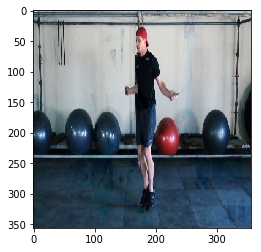

In [10]:
plt.imshow(image_data[index])
plt.show()

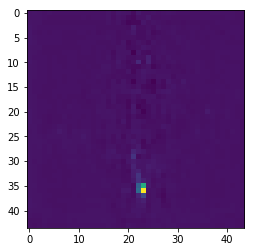

In [11]:
plt.imshow(transposed_heatmap[index][0])
plt.show()

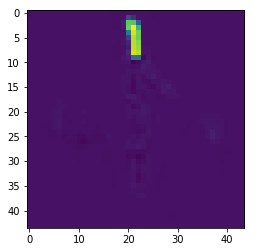

In [12]:
plt.imshow(transposed_vectormap[index][0])
plt.show()

In [13]:
heatmap_output = sum_of_channel(heatmap)
vectormap_output = sum_of_channel(vectormap)

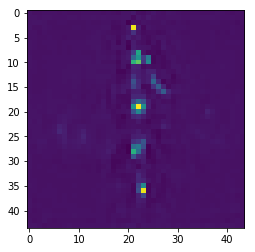

In [14]:
plt.imshow(heatmap_output[index])
plt.show()

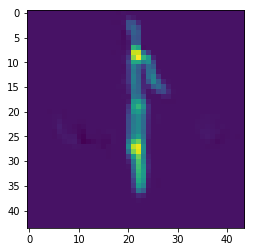

In [15]:
plt.imshow(vectormap_output[index])
plt.show()

In [16]:
MPII_Pairs = [(9, 8), (8, 13), (8, 12), (8, 7), (12, 11), (11, 10), (13, 14), (14, 15), \
              (7, 6), (6, 3), (3, 4), (4, 5), (6, 2), (2, 1), (1, 0)]#16개 조인트, 15개 limb
MPII_Pairs_Render = MPII_Pairs[:]
MPII_Pairs_Network = [(0, 1), (2, 3), (4, 5), (6, 7), (12, 13), (14, 15), (8, 9), (10, 11), (16, 17), (18, 19),\
                     (22, 23), (24, 25), (20, 21), (26, 27), (28, 29)]#x, y vectormap Pairs 24,25

MPII_Colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0],\
              [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255],\
              [170, 0, 255], [170, 0, 255],[170, 0, 255]]

InterMinAbove_Threshold = 6
Inter_Threashold = 1e-08#0.1
Min_Subset_Cnt = 0#4
Min_Subset_Score = 0.01#0.8
#Max_Human = 96
def non_max_suppression(np_input, window_size=5, threshold=0.1):
    under_threshold_indices = np_input < threshold
    np_input[under_threshold_indices] = 0
    return np_input*(np_input == maximum_filter(np_input, footprint=np.ones((window_size, window_size))))

def estimate_pose(coords, heatmap_buffer, heatmap, vectormap):
    """
    [(12, 11), (11, 10), (13, 14), (14, 15)]
    0 - r_ankle
    1 - r_knee
    2 - r_hip
    3 - l_hip
    4 - l_knee
    5 - l_ankle
    6 - pelvis
    7 - thorax
    8 - upper neck
    9 - head top
    10 - r_wrist
    11 - r_elbow
    12 - r_sholder
    13 - l_sholder
    14 - l_elbow
    15 - l_wrist
    16 - back_ground
    """

    connection_all = []
    for (idx1, idx2), (paf_x_idx, paf_y_idx) in zip(MPII_Pairs, MPII_Pairs_Network):
        print("idx1, idx2 : ", idx1, idx2)
        print("paf_x_idx, paf_y_idx : ", paf_x_idx, paf_y_idx)
        connection = estimate_pose_pair(coords, idx1, idx2, vectormap[paf_x_idx], vectormap[paf_y_idx])
        #print("estimate_pose -> idx1, idx2 : ",idx1, idx2)
        #estimate_pose_pair(coords, idx1, idx2, vectormap[paf_x_idx], vectormap[paf_y_idx])
        connection_all.extend(connection)

    print("connection_all : ", connection_all)
    connection_by_human = dict()
    for idx, c in enumerate(connection_all):
        connection_by_human['human_%d' % idx] = [c]
    print("connection_by_human : ", connection_by_human)
    no_merge_cache = defaultdict(list)

    while True:
        is_merged = False
        for k1, k2 in itertools.combinations(connection_by_human.keys(), 2):
            if k1 == k2:
                continue
            if k2 in no_merge_cache[k1]:
                continue
            for c1, c2 in itertools.product(connection_by_human[k1], connection_by_human[k2]):
                if len(set(c1['uPartIdx']) & set(c2['uPartIdx'])) > 0:
                    is_merged = True
                    connection_by_human[k1].extend(connection_by_human[k2])
                    connection_by_human.pop(k2)
                    break
            if is_merged:
                no_merge_cache.pop(k1, None)
                break
            else:
                no_merge_cache[k1].append(k2)

        if not is_merged:
            break


    connection_by_human = {k: v for (k, v) in connection_by_human.items() if len(v) >= Min_Subset_Cnt}
    # reject by subset max score
    print("connection_by_human2 : ", connection_by_human)
    connection_by_human = {k: v for (k, v) in connection_by_human.items() if max([ii['score'] for ii in v])\
                           >= Min_Subset_Score}
    print("connection_by_human2 : ", connection_by_human)
    return [connections_to_human(conn, heatmap_buffer) for conn in connection_by_human.values()]

def connections_to_human(connections, heatMat):
    point_dict = defaultdict(lambda: None)
    for conn in connections:
        point_dict[conn['partIdx'][0]] = (conn['partIdx'][0], (conn['c1'][0] / heatMat.shape[2], conn['c1'][1] / heatMat.shape[1]), heatMat[conn['partIdx'][0], conn['c1'][1], conn['c1'][0]])
        point_dict[conn['partIdx'][1]] = (conn['partIdx'][1], (conn['c2'][0] / heatMat.shape[2], conn['c2'][1] / heatMat.shape[1]), heatMat[conn['partIdx'][1], conn['c2'][1], conn['c2'][0]])
    return point_dict

def estimate_pose_pair(coords, partIdx1, partIdx2, pafMatX, pafMatY):

    connection_temp = []
    peak_coord1, peak_coord2 = coords[partIdx1], coords[partIdx2]
    cnt = 0
    print("peak_coord1, peak_coord2 : ", peak_coord1, peak_coord2)
    for idx1, (y1, x1) in enumerate(zip(peak_coord1[0], peak_coord1[1])):
        for idx2, (y2, x2) in enumerate(zip(peak_coord2[0], peak_coord2[1])):
            print("estimate_pose_pair -> x1, y1, x2, y2 : ", x1, y1, x2, y2)
            score, count = get_score(x1, y1, x2, y2, pafMatX, pafMatY)
            cnt = cnt + 1
            print("estimate_pose_pair -> score : ", score, "idx : ", (idx1, idx2) )
            if (partIdx1, partIdx2) in [(12, 11), (11, 10), (13, 14), (14, 15)]:
                print("estimate_pose_pair -> partIdx1, partIdx2 : ", partIdx1, partIdx2)
                if (count < (InterMinAbove_Threshold // 2) or score <= 0.0):#count < InterMinAbove_Threshold // 2 or 
                    print("estimate_pose_pair -> okokokokokokokokok")
                    continue
            
            elif (count < InterMinAbove_Threshold or  score <= 0.0):#count < InterMinAbove_Threshold or 
                print("estimate_pose_pair -> ----------------------------")
                continue
            print("estimate_pose_pair -> if 통과")
            connection_temp.append({
                'score': score,
                'c1': (x1, y1),
                'c2': (x2, y2),
                'idx': (idx1, idx2),
                'partIdx': (partIdx1, partIdx2),
                'uPartIdx': ('{}-{}-{}'.format(x1, y1, partIdx1), '{}-{}-{}'.format(x2, y2, partIdx2))
            })
            
            print("estimate_pose_pair -> connection temp : ", connection_temp)#empty
    connection = []
    used_idx1, used_idx2 = [], []
    for candidate in sorted(connection_temp, key=lambda x: x['score'], reverse=True):
        # check not connected
        if candidate['idx'][0] in used_idx1 or candidate['idx'][1] in used_idx2:
            continue
        connection.append(candidate)
        used_idx1.append(candidate['idx'][0])
        used_idx2.append(candidate['idx'][1])
    #print("connection : ",connection)
    return connection
def get_score(x1, y1, x2, y2, pafMatX, pafMatY):
    __num_inter = 10
    __num_inter_f = float(__num_inter)
    dx, dy = x2 - x1, y2 - y1
    normVec = math.sqrt(dx ** 2 + dy ** 2)

    if normVec < 1e-4:
        return 0.0, 0

    vx, vy = dx / normVec, dy / normVec

    xs = np.arange(x1, x2, dx / __num_inter_f) if x1 != x2 else np.full((__num_inter, ), x1)
    ys = np.arange(y1, y2, dy / __num_inter_f) if y1 != y2 else np.full((__num_inter, ), y1)
    xs = (xs + 0.5).astype(np.int8)
    ys = (ys + 0.5).astype(np.int8)

    # without vectorization
    pafXs = np.zeros(__num_inter)
    pafYs = np.zeros(__num_inter)
    """for idx, (mx, my) in enumerate(zip(xs, ys)):
        print("get_score -> my, mx : ",my, mx)
        print("get_score -> pafXs's shape : ",np.shape(pafXs))
        print("get_score -> pafYs's shape : ",np.shape(pafYs))

        pafXs[idx] = pafMatX[my][mx]#[my][mx]
        pafYs[idx] = pafMatY[my][mx]"""

    # vectorization slow?
    pafXs = pafMatX[ys, xs]
    pafYs = pafMatY[ys, xs]

    local_scores = pafXs * vx + pafYs * vy
    thidxs = local_scores > Inter_Threashold

    return sum(local_scores * thidxs), sum(thidxs)


def cb_showimg(img, preprocessed, heatmap, vectormap, humans, show_process=False):

    # display
    image = img
    image_w, image_h = image.shape[:2]
    image = draw_humans(image, humans)
    scale = 356.0 / image_w
    newh, neww = 356, int(scale * image_h + 0.5)

    image = cv2.resize(image, (neww, newh), interpolation=cv2.INTER_AREA)

    if show_process:
        process_img = display_image(preprocessed, heatmap, vectormap, as_numpy=True)
        process_img = cv2.resize(process_img, (356 + 356, 356), interpolation=cv2.INTER_AREA)

        canvas = np.zeros([356, 356 + 356 + neww, 3], dtype=np.uint8)
        canvas[:, :356 + 356] = process_img
        canvas[:, 356 + 356 :] = image

    else:
        canvas = image

    #cv2.putText(canvas, "FPS: %f" % (1.0 / (time.time() - fps_time)), (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    #cv2.imshow('openpose', canvas)
    plt.imsave("result.jpg", canvas)
    plt.imshow(canvas, aspect='auto')
    plt.show()


def draw_humans(img, human_list):
    img_copied = np.copy(img)
    image_w, image_h = img_copied.shape[:2]
    #print(np.shape(img_copied))
    centers = {}
    for human in human_list:
        part_idxs = human.keys()
        #print("part_idxs : ", part_idxs)
        # draw point
        for i in range(17):
            if i not in part_idxs:
                continue
            part_coord = human[i][1]
            center = (int(part_coord[0] * image_w + 0.5), int(part_coord[1] * image_h + 0.5))
            print("center : ", center)
            centers[i] = center
            #m = im.transpose((1, 2, 0)).astype(np.uint8).copy() 
            img_copied = img_copied.astype(np.float32).copy()
            cv2.circle(img_copied, center, 3, MPII_Colors[i], thickness=3, lineType=8, shift=0)

        # draw line
        #for pair_order, pair in enumerate(MPII_Pairs_Render):
        #    if pair[0] not in part_idxs or pair[1] not in part_idxs:
        #        continue
        #
        #    img_copied = cv2.line(img_copied, centers[pair[0]], centers[pair[1]], MPII_Colors[pair_order], 3)

    return img_copied

def display_image(inp, heatmap, vectmap, as_numpy=False):
    if as_numpy:
        mpl.use('Agg')

    fig = plt.figure()
    a = fig.add_subplot(2, 2, 1)
    a.set_title('Image')
    plt.imshow(get_bgimg(inp))

    a = fig.add_subplot(2, 2, 2)
    a.set_title('Heatmap')
    #inp = inp.transpose((2, 0, 1))
    #print(np.shape(heatmap))#17 44 44
    plt.imshow(get_bgimg(inp, target_size=(heatmap.shape[1], heatmap.shape[2])), alpha=0.5)################
    #heatmap = heatmap.transpose((2, 0, 1))
    tmp = np.amax(heatmap, axis=0)
    
    plt.imshow(tmp, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()

    tmp2 = vectmap.transpose((2, 0, 1))
    tmp2_odd = np.amax(np.absolute(tmp2[::2, :, :]), axis=0)
    tmp2_even = np.amax(np.absolute(tmp2[1::2, :, :]), axis=0)

    a = fig.add_subplot(2, 2, 3)
    a.set_title('Vectormap-x')
    plt.imshow(get_bgimg(inp, target_size=(vectmap.shape[0], vectmap.shape[1])), alpha=0.5)
    plt.imshow(tmp2_odd, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()

    a = fig.add_subplot(2, 2, 4)
    a.set_title('Vectormap-y')
    plt.imshow(get_bgimg(inp, target_size=(vectmap.shape[0], vectmap.shape[1])), alpha=0.5)
    plt.imshow(tmp2_even, cmap=plt.cm.gray, alpha=0.5)
    plt.colorbar()

    if not as_numpy:
        plt.show()
    else:
        fig.canvas.draw()
        data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        fig.clear()
        plt.close()
        return data
def get_bgimg(inp, target_size=None):
    if target_size:
        inp = cv2.resize(inp, target_size, interpolation=cv2.INTER_AREA)
    inp = cv2.cvtColor(((inp + 1.0) * (255.0 / 2.0)).astype(np.uint8), cv2.COLOR_BGR2RGB)
    return inp
def preprocess(img, width, height):
    val_image = cv2.resize(img, (width, height))
    val_image = val_image.astype(float)
    val_image = val_image * (2.0 / 255.0) - 1.0
    return val_image

In [17]:
oriImg = image_data[index]

In [18]:
resized_heatmap = np.zeros((b_size, 17, 356, 356))
for i in range(b_size):
    for c in range(17):
        resized_heatmap[i][c] = cv2.resize(transposed_heatmap[i][c], (356, 356))
        
transposed_resized_heatmap = np.transpose(resized_heatmap, [0, 2, 3, 1])
transposed_resized_heatmap = transposed_resized_heatmap[index]

In [19]:
resized_vectormap = np.zeros((b_size, 34, 356, 356))
for i in range(b_size):
    for c in range(34):
        resized_vectormap[i][c] = cv2.resize(transposed_vectormap[i][c], (356, 356))
        
transposed_resized_vectormap = np.transpose(resized_vectormap, [0, 2, 3, 1])
transposed_resized_vectormap = transposed_resized_vectormap[index]

In [20]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 17))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 34))


heatmap_avg = heatmap_avg + transposed_resized_heatmap
paf_avg = paf_avg + transposed_resized_vectormap

In [21]:
resized_heatmap = resized_heatmap[index]
resized_vectormap = resized_vectormap[index]

In [22]:
all_peaks = []
peak_counter = 0

for part in range(17-1):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    #print(np.shape(map_left))
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up,map>=map_down, map > 0.07))#0.1
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [23]:
limbSeq = [(9, 8), (8, 13), (8, 12), (8, 7), (12, 11), (11, 10), (13, 14), (14, 15), \
           (7, 6), (6, 3),  (3, 4),  (4, 5), (6, 2),   (2, 1),   (1, 0)]#16개 조인트, 15개 limb

mapIdx = [(16, 17), (18, 19), (20, 21), (22, 23), (28, 29), (30, 31), (24, 25), (26, 27), (32, 33),\
          (34, 35), (38, 39), (40, 41), (36, 37), (42, 43), (44, 45)]

In [24]:
print(np.shape(paf_avg))
connection_all = []
special_k = []
mid_num = 8###########################################################################################
#paf_avg = resized_vectormap
for k in range(len(mapIdx)):
    score_mid = paf_avg[:,:,[x-17 for x in mapIdx[k]]]
    #print("score_mid : ",np.shape(score_mid))
    candA = all_peaks[limbSeq[k][0]]#all_peaks[limbSeq[k][0]-1]#157
    candB = all_peaks[limbSeq[k][1]]#all_peaks[limbSeq[k][1]-1]#246
    #candA : [(182, 68, 0.8127860426902771, 9)]
    #candB :[(173, 92, 0.8721999526023865, 8)]
    #print("candA, candB : ",candA, candB)
    nA = len(candA)
    nB = len(candB)
    #print("nA, nB : ", nA, nB)
    indexA, indexB = limbSeq[k]
    #print("indexA, indexB : ", indexA, indexB)
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                # failure case when 2 body parts overlaps
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)
                
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                #print("startend : ",startend)
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])

                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                criterion1 = len(np.nonzero(score_midpts > 0.05)[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])
        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break
        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

(356, 356, 34)


In [25]:
subset = -1 * np.ones((0, 18))######################################################
#print("subset1 : ", subset)
candidate = np.array([item for sublist in all_peaks for item in sublist])
print("candidate : ", candidate)
#print("all_peaks : ", all_peaks)
for k in range(len(mapIdx)):
    #print("--------------------------------------------")
    #print("k : ", k)
    #print("special_k : ", special_k)
    if k not in special_k:
        #print("k is not in special_k : ",k)
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1
        
        #print("connection_all : ",connection_all)
        #print("connection_all[k] : ",connection_all[k])
        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            #print("hello")
            found = 0
            subset_idx = [-1, -1]
            #print("subset's length :", len(subset))
            for j in range(len(subset)): #1:size(subset,1):
                #print("subset3 : ", subset)
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            #print("found : ",found)
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                #print ("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 15:
                row = -1 * np.ones(18)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])
#print("end~",subset)

candidate :  [[1.89000000e+02 2.93000000e+02 1.74469382e-01 0.00000000e+00]
 [1.74000000e+02 2.28000000e+02 2.87660420e-01 1.00000000e+00]
 [1.74000000e+02 1.58000000e+02 2.67304331e-01 2.00000000e+00]
 [1.89000000e+02 1.57000000e+02 2.73353517e-01 3.00000000e+00]
 [1.85000000e+02 2.23000000e+02 1.22332983e-01 4.00000000e+00]
 [1.84000000e+02 2.24000000e+02 1.21427141e-01 5.00000000e+00]
 [1.90000000e+02 2.94000000e+02 3.47704500e-01 6.00000000e+00]
 [1.82000000e+02 1.58000000e+02 3.70854944e-01 7.00000000e+00]
 [1.82000000e+02 8.30000000e+01 3.27180952e-01 8.00000000e+00]
 [1.81000000e+02 6.90000000e+01 2.95756578e-01 9.00000000e+00]
 [1.74000000e+02 2.80000000e+01 4.88218993e-01 1.00000000e+01]
 [1.74000000e+02 8.40000000e+01 3.02566975e-01 1.10000000e+01]
 [1.97000000e+02 8.10000000e+01 2.34500423e-01 1.20000000e+01]
 [2.06000000e+02 1.16000000e+02 1.85777619e-01 1.30000000e+01]
 [2.21000000e+02 1.32000000e+02 1.00892261e-01 1.40000000e+01]]


In [26]:
# delete some rows of subset which has few parts occur
deleteIdx = [];
print(subset)
for i in range(len(subset)):
    print("subset[i][-1] : ", subset[i][-1])
    print("subset[i][-2]/subset[i][-1] : ",subset[i][-2]/subset[i][-1])
    if subset[i][-1] < 1 or subset[i][-2]/subset[i][-1] < 0.1:#0.1
        deleteIdx.append(i)
    #    print(i)
subset = np.delete(subset, deleteIdx, axis=0)
#print(subset)

[[-1.         -1.         -1.         -1.         -1.          7.
   8.          9.         10.         -1.         -1.         11.
  12.         13.         14.         -1.          5.02300606  8.        ]
 [-1.         -1.          3.          4.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.          1.13592553  2.        ]
 [-1.         -1.         -1.          5.          6.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.          1.20608117  2.        ]
 [ 1.          2.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.          2.12102055  1.        ]]
subset[i][-1] :  8.0
subset[i][-2]/subset[i][-1] :  0.6278757573857956
subset[i][-1] :  2.0
subset[i][-2]/subset[i][-1] :  0.5679627653783861
subset[i][-1] :  2.0
subset[i

In [27]:
test_image = "./MPII_Dataset/test_set_288/image/" + "000298013" + ".jpg" 

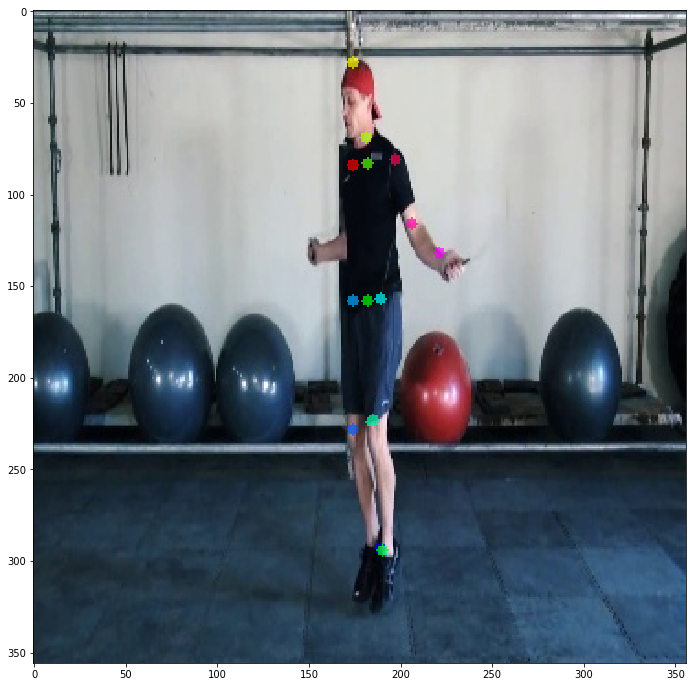

In [28]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

#canvas = batch_img[index]# B,G,R order
canvas = cv2.imread(test_image) # B,G,R order

for i in range(16):
    rgba = np.array(cmap(1 - i/16. - 1./32))
    rgba[0:3] *= 255
    
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 3, colors[i], thickness=-1)

oriImg = cv2.imread(test_image)
to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

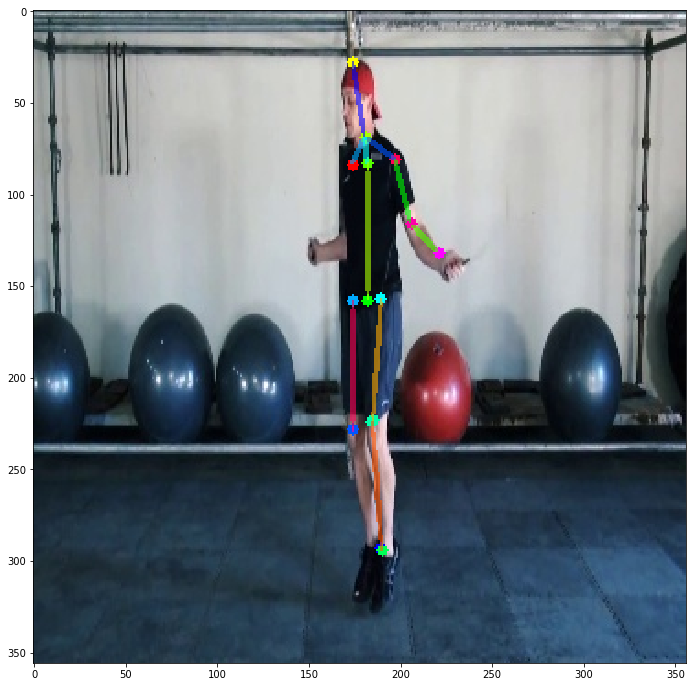

In [29]:
stickwidth = 1

for i in range(15):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        #print("index : ", index)
        if -1 in index:
            continue
        #print("hello")
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)